# Datathon Beginner's Track ML Model
### Created by: Ben Allen, Adam Swartz, Yuv Sachdeva, Lauren Yu
### Date: 1/28/22 - 1/29/22
### Objective: Create an ML model that can predict interest rates on mortgages in Harris County, TX

## Importing Packages and Data

In [12]:
# Standard ML Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

# Preprocessing Imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Model Import
from xgboost import XGBRegressor

# Data Import
mortgage_data = pd.read_csv("track.csv")
print(mortgage_data.head())

   year state_code  county_code      msa  census_tract applicant_age  \
0  2019         TX      48201.0  26420.0  4.820142e+10         45-54   
1  2019         TX      48201.0  26420.0  4.820143e+10         55-64   
2  2019         TX      48201.0  26420.0  4.820122e+10         45-54   
3  2019         TX      48201.0  26420.0  4.820152e+10         55-64   
4  2019         TX      48201.0  26420.0  4.820133e+10         65-74   

   applicant_age_above_62                                       race  \
0                     0.0  Native Hawaiian or Other Pacific Islander   
1                     0.0                                      White   
2                     0.0                                      Asian   
3                     1.0                                      White   
4                     1.0                                      White   

                ethnicity     sex  ...  lender_credits loan_amount  \
0      Hispanic or Latino    Male  ...             NaN     95000

## Cleaning Missing Data
We will drop any columns that are missing 30% or more data values. This drops *denial_reason, lender_credits, discount_points*, and *purchaser_type*.
We will also drop missing values from the *debt_to_income_ratio* column because we will later use ordinal encoding on it. 

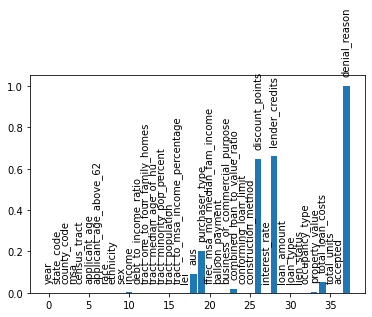

In [33]:
# Checking what percent of each column is missing
percent_missing = mortgage_data.isna().sum()/mortgage_data.shape[0]
# Plotting results
perc_missing_chart = plt.bar(x=range(38), height=percent_missing, width=0.8)
plt.bar_label(container=perc_missing_chart, labels=mortgage_data.columns,
              rotation='vertical', padding=10)
plt.show()

# Removing missing values from debt_to_income_ratio column
mortgage_data.dropna(subset=['debt_to_income_ratio'], inplace=True)

## Selecting Data and Target Columns
We select columns based off apparent usefulness to prediction, whether they will introduce data leakage, and whether they are redundant.
Our target column is *interest_rate*
We will remove any entries that are missing an *interest_rate* value because those entries cannot be used to predict the interest rate.
We then separate our selected columns into unordered categorical data, ordered categorical data, and numerical data.

In [14]:
include_columns = ['year',  # General Data
                   'race', 'ethnicity', 'sex', 'applicant_age',  # Demographic Data
                   'income', 'debt_to_income_ratio',  # Applicant Finances
                   'tract_minority_pop_percent', 'tract_population', 'tract_to_msa_income_percentage',  # Tract Data
                   'balloon_payment', 'combined_loan_to_value_ratio', 'loan_amount', 'loan_type', 'lien_status',
                   'total_loan_costs',  # Loan Data ^
                   'construction_method', 'property_value', 'total_units', 'occupancy_type' # Property Data
                  ]
target_column = ['interest_rate']
                   
# We remove entries with no interest rate value because they can't be used to predict the interest rate
mortgage_data.dropna(axis=0, subset=['interest_rate'], inplace=True)
sanity_check = mortgage_data[mortgage_data.accepted == 0]
print(sanity_check.shape)  # No rejected mortgages with an interest rate as expected

# Assigning X and y
X = mortgage_data[include_columns]
y = mortgage_data[target_column]

# Classifying categorical and numerical columns
unordered_cat_col = ['race', 'ethnicity', 'sex', 'loan_type', 'lien_status', 'construction_method', 'occupancy_type']
ordered_cat_col = ['applicant_age', 'debt_to_income_ratio']
numerical_col = X.select_dtypes(include="number").columns

(0, 38)


## Splitting Data and Preprocessing
We start by ordinally encoding the ordered categorical data. We only have two of these, so it is convenient enough to explicitly sort them using a list and the OrdinalEncoder() function.


After that, we split the data into training, validation, and test data using the test_train_split() function.


It is now convenient to use scikit-learn Pipelines to do the rest of the preprocessing. We do this by making transforms for the three types of columns.


We will use imputation to clean the rest of the missing values because there are relatively few per column because of our initial data cleaning.
For numerical data we will use the StandardScaler() function, so that it works nicely with our XGBRegressor model.

In [15]:
# Ordinal Encoding - Code is adapted from Datathon Beginner's Workshop
age_sort = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']
age_encode = OrdinalEncoder(categories=[age_sort])
X['applicant_age'] = age_encode.fit_transform(X['applicant_age'].values.reshape(-1, 1))

ratio_sort = ['<20%', '20%-<30%', '30%-<36%', '36%-<41%', '41%-<46%', '46%-<50%', '50%-60%', '>60%']
ratio_encode = OrdinalEncoder(categories=[ratio_sort])
X['debt_to_income_ratio'] = ratio_encode.fit_transform(X['debt_to_income_ratio'].values.reshape(-1, 1))

# Creating test data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
# Creating training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=24)

# Creating preprocessing transforms for data
unordered_cat_transform = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='most_frequent')),
    ('oh_encoding', OneHotEncoder(handle_unknown='ignore'))])
ordered_cat_transform = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='most_frequent'))])
numerical_transform = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='mean')),
    ('scaling', StandardScaler())])  # Using scaler for XGBRegressor
preprocessing_transform = ColumnTransformer(transformers=[
    ('unordered_category', unordered_cat_transform, unordered_cat_col),
    ('ordered_category', ordered_cat_transform, ordered_cat_col),
    ('number', numerical_transform, numerical_col)])

C:\Users\jackt\AppData\Local\Temp\ipykernel_18036\4009538008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['applicant_age'] = age_encode.fit_transform(X['applicant_age'].values.reshape(-1, 1))
C:\Users\jackt\AppData\Local\Temp\ipykernel_18036\4009538008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['debt_to_income_ratio'] = ratio_encode.fit_transform(X['debt_to_income_ratio'].values.reshape(-1, 1))


## Defining, Fitting, and Predicting with Initial Model
Next, we will use the xgboost (extreme gradient boosting) algorithm for our model. Specifically, we will use the XGBRegressor algorithm because we are solving a regression problem. We settled on the xgboost algorithm because it is a famously efficient algorithm that produces highly accurate results.


We will start with the base parameters of *n_estimators* = 100, *learning_rate* = 0.05, and *n_jobs* = 2. Later; we will tune *n_estimators* and *learning_rate* to improve performance.


Before we fit the model and predict values, we need to combine the preprocessing transforms we created above with the model using another scikit-learn pipeline.

In [16]:
# Code in this cell is adapted from https://www.kaggle.com/alexisbcook/xgboost
# Defining model
initial_model = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=6)

# Combining preprocessing transforms and model into pipeline
initial_pipeline = Pipeline(steps=[('preprocessing', preprocessing_transform), ('model', initial_model)])

# Fitting model
initial_pipeline.fit(X_train, y_train)

# Initial Predictions of Interest Rates
initial_prediction = initial_pipeline.predict(X_val)

## Evaluating Initial Performance
We will use the cross validation technique to evaluate our model because we are working with a relatively small dataset, and cross validation improves the accuracy of our model's evaluation. We will use 3 folds to reduce the time to validate, and this should still result in an good evaluation.


Given we are solving a regression problem and not a classification model, we cannot use precision and recall to evaluate our model. Instead we will use the mean absolute error because it is outlier resiliant and easy to interpret.


Source: https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

In [17]:
# Code adapted from https://www.kaggle.com/alexisbcook/cross-validation
initial_scores = -1 * cross_val_score(initial_pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')
print(initial_scores.mean())

0.600394015692403


## Tuning n_estimators and learning_rate parameters
Doing this, we get an average MAE of 0.6 meaning our model was able to predict the interest rate within almost half a percent on average. This is a good start, but there’s still more improvements to be made.


To make these improvements, we will tune the *n_estimators* and *learning_rate* hyperparameters of the XGBRegressor model. We will define a function that goes through the same steps our initial model went through. This function will output the average score received from cross validation for each variation in parameter and return it as a list.


Doing this, we see that minimum error is achieved with *n_estimators* = 400 and *learning_rate* = 0.1. Applying these to our model, we are able to reduce the error by almost 0.02.

In [19]:
# Code for cross_score_test_nest and cross_score_test_lrate are adapted from https://www.kaggle.com/alexisbcook/cross-validation
# Tuning n_estimators parameter
n_estimators_list = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


def cross_score_test_nest(n_est):
    standard_pipeline = Pipeline(steps=[('preprocessing', preprocessing_transform),
                                        ('model', XGBRegressor(n_estimators=n_est, learning_rate=0.05, n_jobs=6))])
    scores = -1 * cross_val_score(standard_pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()


nest_score_list = []
for n_est in n_estimators_list:
    nest_score_list.append(cross_score_test_nest(n_est))

print(nest_score_list)

# Tuning learning_rate parameter
learning_rate_list = [0.01, 0.05, 0.1, 0.15, 0.2]


def cross_score_test_lrate(learn_rate):
    standard_pipeline = Pipeline(steps=[('preprocessing', preprocessing_transform),
                                       ('model', XGBRegressor(n_estimators=400, learning_rate=learn_rate, n_jobs=6))])
    scores = -1 * cross_val_score(standard_pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()


learn_rate_score_list = []
for learn_rate in learning_rate_list:
    learn_rate_score_list.append(cross_score_test_lrate(learn_rate))

print(learn_rate_score_list)

[0.6444394798908726, 0.600394015692403, 0.5892352111859166, 0.5868501046409347, 0.586147253712283, 0.5862664650085001, 0.586449865225561, 0.5866146393680276, 0.5866831597553531, 0.5870631206787021, 0.5873988127811407]
[0.5985316131487445, 0.586147253712283, 0.5810137742975641, 0.5821830630539657, 0.5930296629327688]


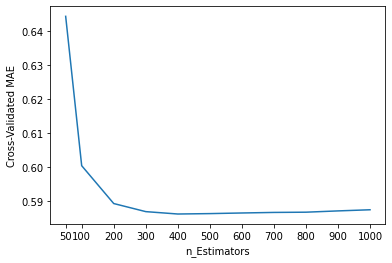

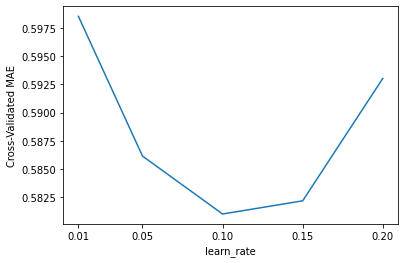

In [39]:
# Plotting changes in MAE due to n_estimator variation
nest_chart = plt.plot(n_estimators_list, nest_score_list)
plt.ylabel('Cross-Validated MAE')
plt.xlabel('n_Estimators')
plt.xticks(n_estimators_list)
plt.show()

# Plotting changes in MAE due to learn_rate variation
nest_chart = plt.plot(learning_rate_list, learn_rate_score_list)
plt.ylabel('Cross-Validated MAE')
plt.xlabel('learn_rate')
plt.xticks(learning_rate_list)
plt.show()

## Final Model and Predictions
With our hyperparameters tuned, we are now ready to make our final prediction for interest rate with our test_data.


With an average MAE of 0.638, the scores from our validation data and test data are similar enough to assume that there was no data leakage in our model.


We now have a model that should be able to predict the interest rate on mortgages in Harris County, TX with an average error of 0.6 - 0.65%. This is a high enough accuracy to be useful for predicting future interest rates on mortgages.

In [20]:
# Final Test Predictions
final_model = XGBRegressor(n_estimators=400, learning_rate=0.1, n_jobs=6)
final_pipeline = Pipeline(steps=[('preprocessing', preprocessing_transform), ('model', final_model)])
final_pipeline.fit(X_train, y_train)
test_predictions = final_pipeline.predict(X_test)

# Evaluating Final Predictions
scores = -1 * cross_val_score(final_pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')
print(scores)
print(scores.mean())

# Outputting Final Predictions
output = pd.DataFrame({'Id': X_test.index,
                       'interest_rate': test_predictions})
output.to_csv('predictions.csv', index=False)

[1.24217929 0.8520317  0.60916245 0.51186701 0.54840496 0.67296225
 0.50607627 0.4827291  0.43706827 0.51922638]
0.6381707673995882
